In [1]:
# pip install tensorflow
# pip install keras
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install scikit-learn
# pip install opencv-contrib-python

ResNet50

In [3]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Canny edge detection
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, 100, 200)
    img = Image.fromarray(edges)
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))


In [3]:
train_dir = 'UC Merced/images_train_test_val/train'
test_dir = 'UC Merced/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [4]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(21, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [5]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 1167s 5s/step - accuracy: 0.7499 - loss: 0.8917 - val_accuracy: 0.0619 - val_loss: 3.3843
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1116s 5s/step - accuracy: 0.9641 - loss: 0.1145 - val_accuracy: 0.0800 - val_loss: 4.5588
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1111s 5s/step - accuracy: 0.9728 - loss: 0.0868 - val_accuracy: 0.2938 - val_loss: 4.5743
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1110s 5s/step - accuracy: 0.9819 - loss: 0.0553 - val_accuracy: 0.8500 - val_loss: 0.5324
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1110s 5s/step - accuracy: 0.9858 - loss: 0.0541 - val_accuracy: 0.9452 - val_loss: 0.1741
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1108s 5s/step - accuracy: 0.9889 - loss: 0.0447 - val_accuracy: 0.9471 - val_loss: 0.2084
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1103s 5s/step - accuracy: 0.9881 - loss: 0.0346 - val_accuracy: 0.9833 - val_loss: 0.0722
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1105s 5s/step - accuracy: 0.9905 - loss: 0.0330 - val_accurac

230/230 ━━━━━━━━━━━━━━━━━━━━ 229s 994ms/step - accuracy: 0.9940 - loss: 0.0217
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 978ms/step - accuracy: 0.9887 - loss: 0.0464
Train accuracy: 0.9952, Validation accuracy: 0.9881


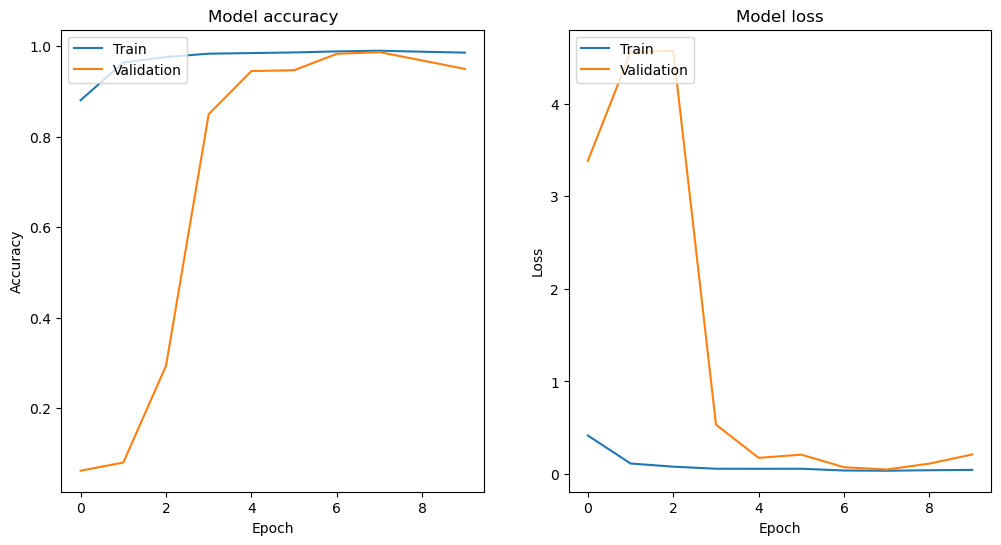

In [6]:
model.load_weights('best_model.keras')

train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


ResNet50 with GridSearch tuning

In [ ]:
# 